In [105]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [106]:
import xgboost as xgb
print(xgb.__version__)

2.1.0


In [107]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import accuracy_score


In [108]:
df = pd.read_csv("C:/Users/singh/Desktop/TIP_2/fraudTest.csv")   #C:/Users/singh/Downloads/fraudTrain.csv 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [109]:
#Summary the description of the dataset
df.describe()

#Distribute the class
df[('is_fraud')].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [110]:
#Split the column trans_date_trans_time into 2 separate columns, including trans_date and trans_time  ##TRAIN
#df['trans_date'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S').dt.date
#df['trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S').dt.time
#df.info()


# Split the 'trans_date_trans_time' into 'trans_date' and 'trans_time'  ## TEST
df['trans_date'] = pd.to_datetime(df['trans_date_trans_time'], format='%d-%m-%Y %H:%M').dt.date
df['trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d-%m-%Y %H:%M').dt.time
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

## Pre-Processing

In [111]:
# Remove the 'trans_date_trans_time' column
# Check if the index column exists and remove it
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
df.drop('trans_date_trans_time', axis=1, inplace=True)

In [112]:
# Reorder the columns to have 'trans_date' first and 'trans_time' second
columns = ['trans_date', 'trans_time'] + [col for col in df.columns if col not in ['trans_date', 'trans_time']]
df = df[columns]

From the dtype of the dataset, we still have some tasks to do with the dtype. First of all, trans_date needed to be transferred from object/string to datetime

In [113]:
# Convert 'dob' to datetime
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')  #format='%d-%m-%Y %H:%M').dt.time

# Convert 'trans_time' to time
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.time

# Convert 'trans_date' to date
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Check the data types
print("\nData types of the columns:")
print(df.dtypes)


Data types of the columns:
trans_date    datetime64[ns]
trans_time            object
cc_num               float64
merchant              object
category              object
amt                  float64
first                 object
last                  object
gender                object
street                object
city                  object
state                 object
zip                    int64
lat                  float64
long                 float64
city_pop               int64
job                   object
dob           datetime64[ns]
trans_num             object
unix_time              int64
merch_lat            float64
merch_long           float64
is_fraud               int64
dtype: object


In [114]:
df.dtypes

trans_date    datetime64[ns]
trans_time            object
cc_num               float64
merchant              object
category              object
amt                  float64
first                 object
last                  object
gender                object
street                object
city                  object
state                 object
zip                    int64
lat                  float64
long                 float64
city_pop               int64
job                   object
dob           datetime64[ns]
trans_num             object
unix_time              int64
merch_lat            float64
merch_long           float64
is_fraud               int64
dtype: object

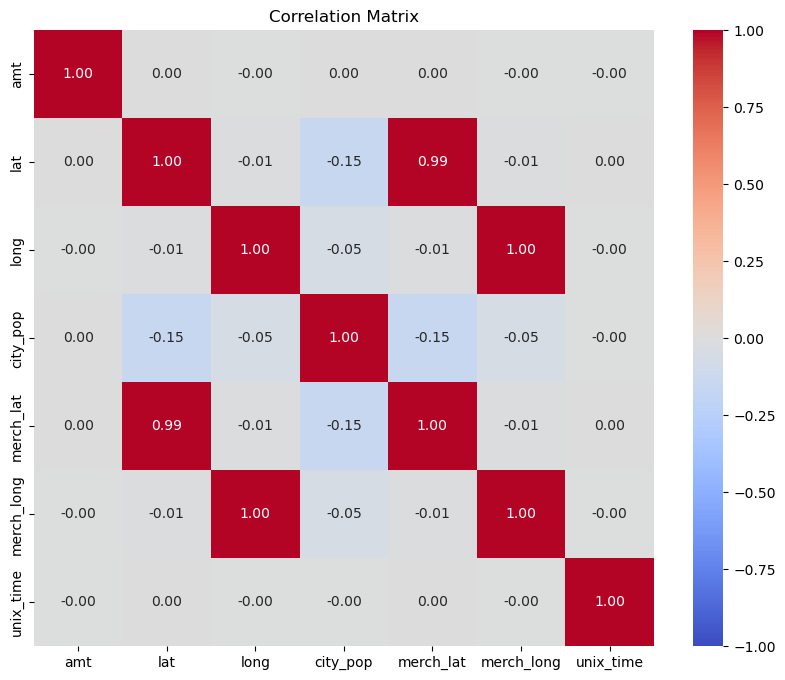

In [115]:
# Select numerical columns
numerical_columns_df = df[['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'unix_time']]
# Compute the correlation matrix
correlation_matrix = numerical_columns_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering

1. Transaction Frequency Features

In [116]:
#Statistic summary of total transaction per user
df['cc_num'].value_counts().agg(['mean', 'median', 'min', 'max'])

mean       614.733407
median     636.500000
min          6.000000
max       2144.000000
Name: count, dtype: float64

In [117]:
# Total transactions of all users per day
df['transactions_per_day'] = df.groupby(['cc_num', df['trans_date'].dt.day])['trans_date'].transform('count')

print(df[['cc_num', 'trans_date', 'transactions_per_day']].head())

         cc_num trans_date  transactions_per_day
0  2.291160e+15 2020-06-21                    21
1  3.573030e+15 2020-06-21                    36
2  3.598220e+15 2020-06-21                    45
3  3.591920e+15 2020-06-21                    29
4  3.526830e+15 2020-06-21                    29


In [118]:
# Create a 'Week' column using ISO calendar weeks
df['Week'] = df['trans_date'].dt.isocalendar().week

# Calculate total transactions per week for each customer
df['transaction_per_week'] = df.groupby(['cc_num', 'Week'])['trans_date'].transform('count')

# Display the updated dataframe with Week and total transactions per Week each customer columns
print(df[['cc_num', 'Week', 'transaction_per_week']].head())

         cc_num  Week  transaction_per_week
0  2.291160e+15    25                     2
1  3.573030e+15    25                     4
2  3.598220e+15    25                     3
3  3.591920e+15    25                     3
4  3.526830e+15    25                     4


In [119]:
# Calculate total transactions per month for all users
total_transactions_per_month = df.groupby(df['trans_date'].dt.month).size()
# Display the total transactions per month
print(total_transactions_per_month)

trans_date
6      30058
7      85848
8      88759
9      69533
10     69348
11     72635
12    139538
dtype: int64


In [120]:
#Transaction per season of all users
def season(date):
    if date.month in [1, 2, 3]:
        return 'Autumn'
    elif date.month in [4, 5, 6]:
        return 'Winter'
    elif date.month in [7, 8, 9]:
        return 'Spring'
    else:
        return 'Summer'
df['transactions_per_season'] = df.groupby(['cc_num', df['trans_date'].apply(season)])['trans_date'].transform('count')

print(df.dtypes)
# Total transactions of all users per day
df['transactions_per_month'] = df.groupby(['cc_num', df['trans_date'].dt.month])['trans_date'].transform('count')
print(df[['cc_num', 'trans_date', 'transactions_per_month']].head())

trans_date                 datetime64[ns]
trans_time                         object
cc_num                            float64
merchant                           object
category                           object
amt                               float64
first                              object
last                               object
gender                             object
street                             object
city                               object
state                              object
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                object
dob                        datetime64[ns]
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
transactions_per_day              

2. User Transaction Behavior

In [121]:
## Perform the aggregations
agg_df = df.groupby('cc_num')['amt'].agg(
    avg_trans_amount='mean',
    total_trans_amount='sum',
    med_trans_amount='median',
    std_trans_amount='std'
).reset_index()

# Merge the aggregation results back to the original DataFrame
df = df.merge(agg_df, on='cc_num', how='left')

## 3. User-Based Features: Age and Gender

3.1 Calculate age of user based on DOB and transation date

In [122]:
#Calculate user's age based on date of birth and transaction date
def calculate_age(dob, trans_date):
    return trans_date.year - dob.year - ((trans_date.month, trans_date.day) < (dob.month, dob.day))
df['age'] = df.apply(lambda row: calculate_age(row['dob'], row['trans_date']), axis=1)

#Explore age stat
df['age'].agg(['mean', 'median', 'min', 'max'])

mean      46.390496
median    44.000000
min       15.000000
max       96.000000
Name: age, dtype: float64

3.2 Convert gender into binary values

In [123]:
#Convert gender to binary values
print('\n The number of cutomers based on age is:')
print(df['gender'].value_counts())
print("-" * 40)

#Total transaction amount by gender
print('\nTotal transaction amount made by gender is:')
print(df.groupby('gender')['amt'].sum())
print("-" * 40)

#Average transaction made by gender
print('\n Average transaction amount made by gender is:')
print(df.groupby('gender')['amt'].mean())
print("-" * 40)

# Calculate mean and median of age distribution by gender
print('\n Age Distribution by gender is:')
print(df.groupby('gender')['age'].agg(['mean', 'median']))
print("-" * 40)


 The number of cutomers based on age is:
gender
F    304886
M    250833
Name: count, dtype: int64
----------------------------------------

Total transaction amount made by gender is:
gender
F    21155705.55
M    17407197.56
Name: amt, dtype: float64
----------------------------------------

 Average transaction amount made by gender is:
gender
F    69.388905
M    69.397558
Name: amt, dtype: float64
----------------------------------------

 Age Distribution by gender is:
             mean  median
gender                   
F       46.300604    44.0
M       46.499759    45.0
----------------------------------------


## 4. Fraud Transaction Analysis

4.1 Calculate fraud ratio using fraudulent transactions and total transactions

In [124]:
# Calculate fraudulent transactions per user
fraud_transactions_per_user = df.groupby('cc_num')['is_fraud'].sum().reset_index()
total_transactions_per_user = df.groupby('cc_num').size().reset_index(name='total_transactions')

# Merge to get fraud ratio per user
fraud_ratio_per_user = pd.merge(fraud_transactions_per_user, total_transactions_per_user, on='cc_num')
fraud_ratio_per_user['fraud_ratio'] = fraud_ratio_per_user['is_fraud'] / fraud_ratio_per_user['total_transactions']

# Merge fraud_ratio into the original dataset
df = pd.merge(df, fraud_ratio_per_user[['cc_num', 'fraud_ratio']], on='cc_num', how='left')

Correlation Matrix 

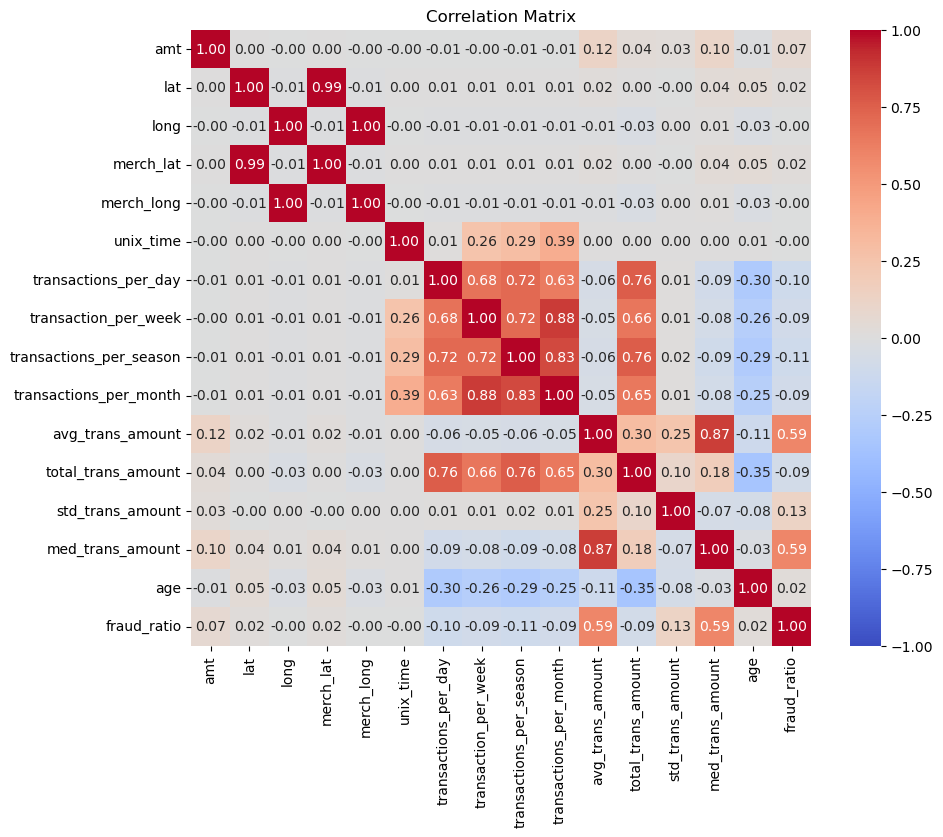

In [125]:
# Assuming df is your original DataFrame
# Convert 'amt' to numeric if necessary
df['amt'] = pd.to_numeric(df['amt'], errors='coerce')

# Create new feature based on transaction amounts
df['amount_log'] = np.log(df['amt'] + 1)

# Select numerical columns
numerical_columns_df = df[['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time', 'transactions_per_day', 'transaction_per_week', 'transactions_per_season', 'transactions_per_month', 'avg_trans_amount', 'total_trans_amount', 'std_trans_amount', 'med_trans_amount', 'age', 'fraud_ratio']]
# Compute the correlation matrix
correlation_matrix = numerical_columns_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 5. Feature Selection

6.1 Chi-Square Test for Categorical Feature Independence with Fraud

In [126]:
from scipy.stats import chi2_contingency

#List of categorical columns to test
categorical_cols = ['Week', 'transaction_per_week', 'transactions_per_month']

# Loop through each categorical column and perform chi-square test
results = []
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['is_fraud'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results.append({'Feature': col, 'Chi2': chi2, 'P-value': p})

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
print("Chi-square test results for categorical features and is_fraud:\n", results_df)

Chi-square test results for categorical features and is_fraud:
                   Feature         Chi2        P-value
0                    Week   453.197099   2.748520e-78
1    transaction_per_week  1077.275234  5.375051e-161
2  transactions_per_month  8758.796067   0.000000e+00


6.2 Correlation Coefficient (Numerical Features)

In [127]:
# Compute Pearson correlation coefficient
correlation = df[['transactions_per_day', 'avg_trans_amount', 'total_trans_amount',
                  'med_trans_amount', 'std_trans_amount', 'age', 'fraud_ratio', 'is_fraud']].corr()['is_fraud']

print("Pearson correlation coefficients:")
print(correlation)

Pearson correlation coefficients:
transactions_per_day   -0.026043
avg_trans_amount        0.180301
total_trans_amount     -0.026285
med_trans_amount        0.180225
std_trans_amount        0.039000
age                     0.007334
fraud_ratio             0.307568
is_fraud                1.000000
Name: is_fraud, dtype: float64


7. Resampling dataset

In [128]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables into numerical values
df['merchant'] = label_encoder.fit_transform(df['merchant'])
df['category'] = label_encoder.fit_transform(df['category'])
df['city'] = label_encoder.fit_transform(df['city'])
df['state'] = label_encoder.fit_transform(df['state'])

In [129]:
# Drop irrelevant or personally identifiable information (PII) columns
df = df.drop(columns=["first", "last", "street", "trans_num", "dob", "trans_date", "trans_time", "job"])

# Apply the mapping to convert 'gender' column to numerical values
df['gender'] = df['gender'].map({'M': 1, 'F': 0})

In [130]:
# Step 3: Split the data into features (X) and target (y)
X = df.drop(columns=['is_fraud'])  # Replace 'is_fraud' with your target column name if different
y = df['is_fraud']  # Replace 'is_fraud' with your target column name if different


## Scaling

c:\Users\singh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\singh\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Classification Report on the test dataset:


c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110718
           1       0.00      0.00      0.00       426

    accuracy                           1.00    111144
   macro avg       0.50      0.50      0.50    111144
weighted avg       0.99      1.00      0.99    111144


Confusion Matrix on the test dataset:
[[110718      0]
 [   426      0]]


c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\singh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


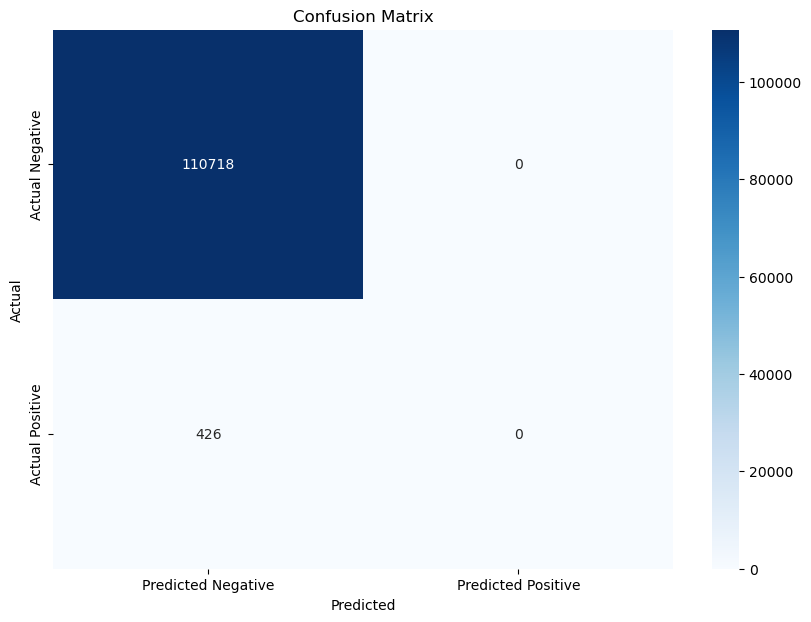

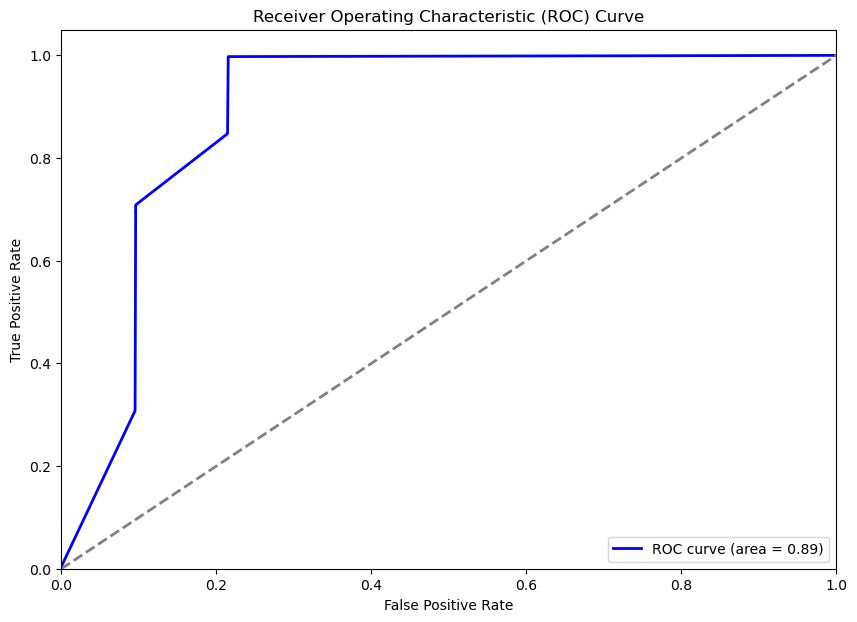

In [131]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import FileLink

# Assuming df is your DataFrame

# Step 1: Split the data into features (X) and target (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load the previously saved Random Forest model
best_rf = joblib.load('my_rf_model.joblib')  # This should match your actual model filename

# Step 4: Make predictions on the scaled test data
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]  # Get predicted probabilities for ROC curve

# Print the classification report
print("Classification Report on the test dataset:")
classification_report_str = classification_report(y_test, y_pred)
print(classification_report_str)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix on the test dataset:")
print(conf_matrix)

# Convert the classification report to a dataframe for easy manipulation
classification_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

# Create a dataframe for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a dataframe for the ROC curve
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': thresholds})

# Visualization of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [132]:
print(df.dtypes)

cc_num                     float64
merchant                     int32
category                     int32
amt                        float64
gender                       int64
city                         int32
state                        int32
zip                          int64
lat                        float64
long                       float64
city_pop                     int64
unix_time                    int64
merch_lat                  float64
merch_long                 float64
is_fraud                     int64
transactions_per_day         int64
Week                        UInt32
transaction_per_week         int64
transactions_per_season      int64
transactions_per_month       int64
avg_trans_amount           float64
total_trans_amount         float64
med_trans_amount           float64
std_trans_amount           float64
age                          int64
fraud_ratio                float64
amount_log                 float64
dtype: object


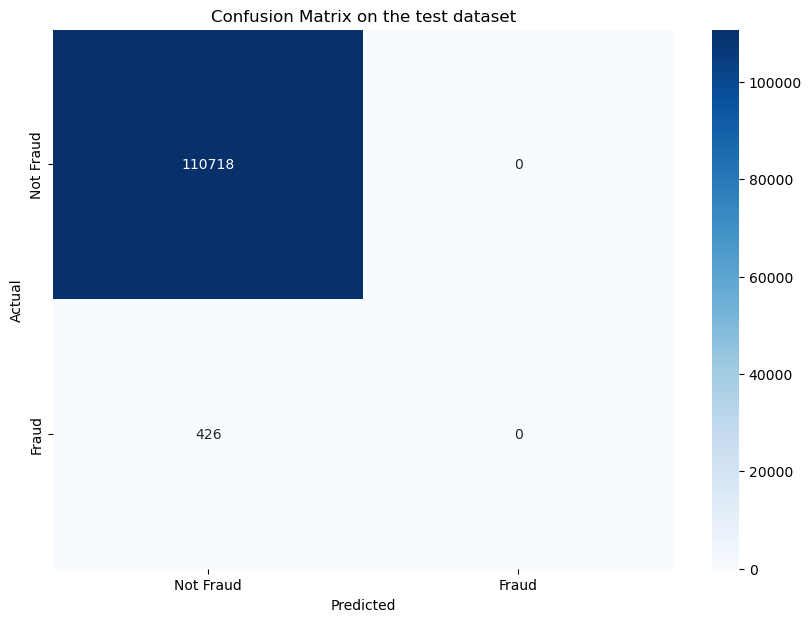


Model accuracy on the test dataset: 0.9961671345281796


In [133]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on the test dataset')
plt.show()
# Print the accuracy of the model on the test dataset
accuracy = accuracy_score(y_test, y_pred)
print("\nModel accuracy on the test dataset:", accuracy)